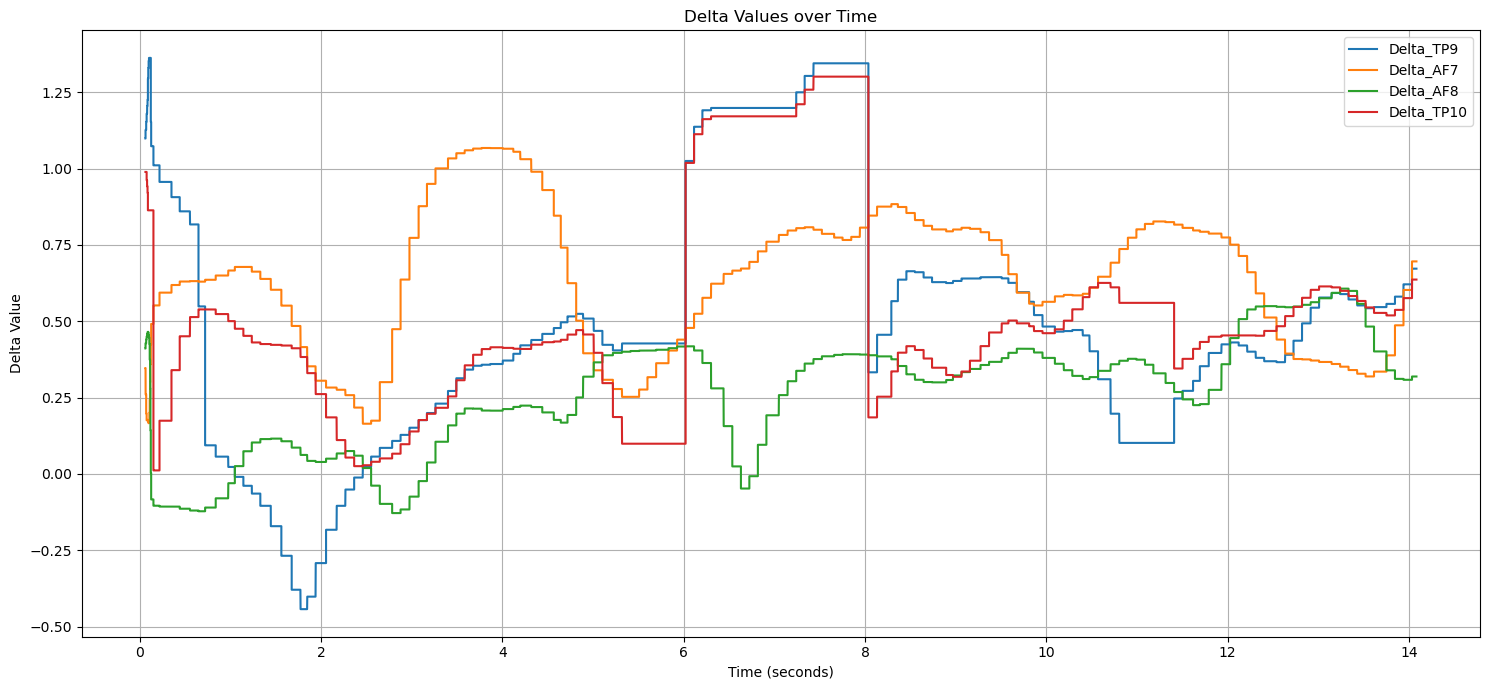

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the filename is "data.csv"
df = pd.read_csv("../data/constant_template.csv")

# Convert the 'TimeStamp' column to datetime format
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

# Calculate seconds from the start of the dataframe
df['Seconds'] = (df['TimeStamp'] - df['TimeStamp'].iloc[0]).dt.total_seconds()

# Filter out rows with missing values for Delta columns
df = df.dropna(subset=['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10'])

# Plotting Delta values with seconds on the x-axis
plt.figure(figsize=(15, 7))
for column in ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10']:
    plt.plot(df['Seconds'], df[column], label=column)

plt.title("Delta Values over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Delta Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import mne
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../data/constant_template.csv')

# Drop rows with missing values for our required columns (like the second row in your sample)
data = data.dropna(subset=['Delta_TP9', 'Delta_AF7', 'Theta_TP9', 'Theta_AF7', 'Alpha_TP9', 'Alpha_AF7', 'Beta_TP9', 'Beta_AF7', 'Gamma_TP9', 'Gamma_AF7'])

In [16]:
# Define the segment size
segment_size = int(0.8 * 256) # this is 204 which is 0.8 seconds

In [20]:
def approximate_entropy(segment, m=2):
    r = 0.2 * np.std(segment)
    
    phi_values = []
    for m in range(2):
        inner_phi = np.mean([np.exp(np.mean(np.abs(segment[j] - segment[j+m]))) for j in range(len(segment) - m)])
        phi_values.append(inner_phi)
    
    phi = np.mean(phi_values)
    return np.log(phi)


In [37]:
# Create empty lists to store our results
approx_entropy = []
total_variation = []
standard_variation = []
energy = []
sample_skewness = []

for i in range(0, len(data), segment_size):
    segment = data['Delta_TP9'].iloc[i:i+segment_size]
    
    if len(segment) < segment_size: break
    segment = segment.reset_index(drop=True)

    # print(segment)
    # Approximate Entropy
    # entropy = approximate_entropy(segment)
    approx_entropy.append(approximate_entropy(segment))
    
    # Total Variation
    total_variation.append(np.sum(np.gradient(segment)))
    
    # Standard Variation (Standard Deviation)
    standard_variation.append(np.std(segment))
    
    # Energy
    energy.append(np.sum(segment**2))
    
    # Skewness
    sample_skewness.append(skew(segment))

# You can now convert these lists into a DataFrame
features_df = pd.DataFrame({
    'Approx. Entropy': approx_entropy,
    'Total variation': total_variation,
    'Standard variation': standard_variation,
    'Energy': energy,
    'Skewness': sample_skewness
})

print(features_df)
print(features_df.shape)

    Approx. Entropy  Total variation  Standard variation      Energy  Skewness
0          0.000637         0.253894            0.077180  308.528797  0.280371
1          0.000962        -0.341782            0.131534  333.957360 -0.911313
2          0.002839        -0.987670            0.374718  101.117031 -0.550211
3          0.001190        -0.465717            0.137601    8.173783 -0.715171
4          0.001279         0.499558            0.163451   11.379412 -0.418512
5          0.000433         0.173464            0.054171    4.761880  0.054459
6          0.000408         0.183972            0.035598   24.365080 -0.925619
7          0.000364         0.115333            0.037541   46.687983 -0.361999
8          0.000318        -0.081486            0.023422   38.319529  1.731899
9          0.002458         0.771152            0.342456  197.307020 -0.704812
10         0.000265         0.104885            0.022840  297.631285  2.555291
11         0.004727        -0.786189            0.34

In [40]:
def add_windows(feature_df, num_windows=9):
    new_features = []

    for i in range(len(feature_df)):
        current_window = feature_df.iloc[i]
        if i < num_windows:
            previous_windows = pd.DataFrame(index=range(num_windows - i), columns=feature_df.columns)
            previous_windows = previous_windows.fillna(0)
            previous_windows = pd.concat([previous_windows, feature_df.iloc[:i]])
        else:
            previous_windows = feature_df.iloc[i - num_windows:i]
        concatenated_features = pd.concat([current_window, previous_windows.unstack()]).reset_index(drop=True)
        new_features.append(concatenated_features)
    
    return pd.DataFrame(new_features)

new_df = add_windows(features_df)

    Approx. Entropy  Total variation  Standard variation      Energy  Skewness
0          0.000637         0.253894            0.077180  308.528797  0.280371
1          0.000962        -0.341782            0.131534  333.957360 -0.911313
2          0.002839        -0.987670            0.374718  101.117031 -0.550211
3          0.001190        -0.465717            0.137601    8.173783 -0.715171
4          0.001279         0.499558            0.163451   11.379412 -0.418512
5          0.000433         0.173464            0.054171    4.761880  0.054459
6          0.000408         0.183972            0.035598   24.365080 -0.925619
7          0.000364         0.115333            0.037541   46.687983 -0.361999
8          0.000318        -0.081486            0.023422   38.319529  1.731899
9          0.002458         0.771152            0.342456  197.307020 -0.704812
10         0.000265         0.104885            0.022840  297.631285  2.555291
11         0.004727        -0.786189            0.34